<a href="https://colab.research.google.com/github/Baafour-D/HeroLogoClassifier/blob/main/herologo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras import layers, models
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
tf.__version__

'2.2.0'

In [9]:
def loadTrain(trainPath, classes, imageSize):
    images = []
    cls = []
    labels = []
    imageNames = []

    print("Reading Training Data")
    print("Path : ", trainPath)
    print("classes : ", classes)
    print("Image Size : ", imageSize)

    for field in classes:

        index = classes.index(field)
        print("Index : ", index, " Class : ", classes[index])
        # index will act as label
        # now build path to particular class
        path = os.path.join(trainPath, field)
        # now list all images in this folder
        print("For class and path --> ", path)
        for image in os.listdir(path):
            cv_img = cv2.imread(os.path.join(path, image))
            # resize
            cv_img = cv2.resize(cv_img, (imageSize, imageSize))
            cv_img = cv_img.astype(np.float64)
            # normalize
            cv_img = np.multiply(cv_img, 1.0 / 255.0)
            images.append(cv_img)  # add to image list
            # add label to image
            label = index#np.zeros(len(classes))
            #label[index] = 1.0  # one hot vector encoding
            labels.append(label)  # label added to list
            imbase = os.path.basename(image)  # base folder
            imageNames.append(imbase)
            cls.append(field)
    # make all list numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    imageNames = np.array(imageNames)
    cls = np.array(cls)

    return images, labels, imageNames, cls


class DataSet(object):

    def __init__(self, images, labels, imageNames, cls):
        self._num_examples = images.shape[0]

        self._images = images
        self._labels = labels
        self._imageNames = imageNames
        self._cls = cls
        self._epochs_done = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def img_names(self):
        return self._imageNames

    @property
    def cls(self):
        return self._cls

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_done(self):
        return self._epochs_done

    def getData(self):
        return self._images, self._labels, self._imageNames, self._cls

    def next_batch(self, batch_size):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size

        if self._index_in_epoch > self._num_examples:
            self._epochs_done += 1
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch

        return self._images[start:end], self._labels[start:end], self._imageNames[start:end], self._cls[start:end]


def readData(trainPath, classes, imageSize, validationSize):
    class DataSets(object):
        pass

    data_sets = DataSets()

    images, labels, imageNames, cls = loadTrain(trainPath, classes, imageSize)
    images, labels, imageNames, cls = shuffle(images, labels, imageNames, cls)
    if isinstance(validationSize, float):
        validationSize = int(validationSize * images.shape[0])

    validationImages = images[:validationSize]
    validationLabels = labels[:validationSize]
    validationImageNames = imageNames[:validationSize]
    validationCls = cls[:validationSize]

    trainImages = images[validationSize:]
    trainLabels = labels[validationSize:]
    trainImgNames = imageNames[validationSize:]
    trainCls = cls[validationSize:]

    data_sets.train = DataSet(trainImages, trainLabels, trainImgNames, trainCls)
    data_sets.valid = DataSet(validationImages, validationLabels, validationImageNames, validationCls)

    return data_sets

In [10]:
validationSize = 0.2
imageSize = 128
numChannels = 3
dataPath = "/content/drive/My Drive/AIproject/data"
classes = os.listdir(dataPath)
numClasses = len(classes)
print("Number of classes are : ", classes)
print("Training data Path : ",dataPath)

Number of classes are :  ['batman', 'flash', 'superman', 'wonderwoman']
Training data Path :  /content/drive/My Drive/AIproject/data


In [11]:
data = readData(dataPath,classes,imageSize,validationSize)

X_train,y_train,names_train,cls_train = data.train.getData()
X_test,y_test,names_test,cls_test = data.valid.getData()

print("Training data X : " , X_train.shape)
print("Training data y : " , y_train.shape)
print("Testing data X : ",X_test.shape)
print("Testing data y : ",y_test.shape)

Reading Training Data
Path :  /content/drive/My Drive/AIproject/data
classes :  ['batman', 'flash', 'superman', 'wonderwoman']
Image Size :  128
Index :  0  Class :  batman
For class and path -->  /content/drive/My Drive/AIproject/data/batman
Index :  1  Class :  flash
For class and path -->  /content/drive/My Drive/AIproject/data/flash
Index :  2  Class :  superman
For class and path -->  /content/drive/My Drive/AIproject/data/superman
Index :  3  Class :  wonderwoman
For class and path -->  /content/drive/My Drive/AIproject/data/wonderwoman
Training data X :  (32, 128, 128, 3)
Training data y :  (32,)
Testing data X :  (8, 128, 128, 3)
Testing data y :  (8,)


In [14]:
X_train[31].shape

(128, 128, 3)

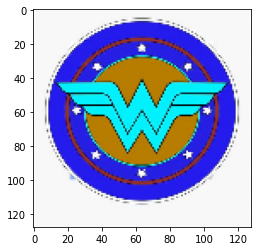

In [21]:
plt.imshow(X_train[31])

In [22]:
classes[y_train[1]]

'flash'

In [23]:
print(X_train.shape)
print(X_test.shape)

(32, 128, 128, 3)
(8, 128, 128, 3)


In [24]:
print(y_train.shape)
print(y_test.shape)


(32,)
(8,)


In [25]:
type(X_test[0][0][0][0])

numpy.float64

In [26]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [28]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
history = model.fit(X_train,y_train, epochs=4, 
                    validation_data=(X_test,y_test))

Epoch 1/4
1/1 [==============================] - 0s 295ms/step - loss: 1.6170 - accuracy: 0.2188 - val_loss: 2.1429 - val_accuracy: 0.2500
Epoch 2/4
1/1 [==============================] - 0s 100ms/step - loss: 1.4579 - accuracy: 0.4375 - val_loss: 1.3890 - val_accuracy: 0.2500
Epoch 3/4
1/1 [==============================] - 0s 94ms/step - loss: 1.3187 - accuracy: 0.3750 - val_loss: 1.5462 - val_accuracy: 0.2500
Epoch 4/4
1/1 [==============================] - 0s 104ms/step - loss: 0.9230 - accuracy: 0.6875 - val_loss: 1.4037 - val_accuracy: 0.3750


1/1 - 0s - loss: 1.4037 - accuracy: 0.3750
Accuracy : 37.5


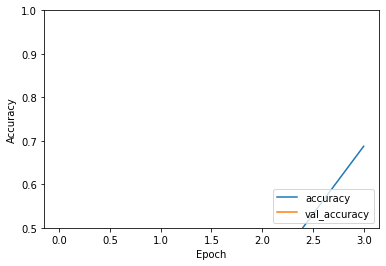

In [30]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print("Accuracy : {}".format(test_acc*100))

In [31]:
model.save("comic.h5")

In [32]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [33]:
model_file = drive.CreateFile({'title' : 'comic.h5'})                       
model_file.SetContentFile('comic.h5')                       
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})


GoogleDriveFile({'id': '1XJBAqgxpfc_muniQFhnvpSHPgnp2lTtA'})

In [37]:
!ls -1

comic.h5
drive
sample_data
